***Volta Analysis Team7***
*Stephen McCarthy, Adam Kielinski, Long Le, Minh Pham*
*14/05/24*

# Table of contents:
1. Preparation
2. Check time-intervals to predict on
3. KMF Analysis on Construction -> Maintenance
4. CoxPH on effect of Covariates on Construction -> Maintenance
5. Saving model
6. Summary of Results: Accuracy, Visualization & Business
7. Further Refinement

# 1. Preparation

In [10]:
# Install required packages using in analysis
%pip install pandas spacy numpy openpyxl pyarrow scipy scikit-learn matplotlib seaborn sacremoses lifelines imbalanced-learn pylance statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 17.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 22.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 19.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 15.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 16.9 

In [4]:
# Load source data into enviroment and check if import succeed
import pandas as pd
df = pd.read_csv("./agressively_cleaned_critical_analysis_df.csv")
df.head

<bound method NDFrame.head of                Product                Unit_Number Device_Manufacturer  \
0     REM000090260      0825405273110                 REMEHA            
1     REM000090260      0825405273110                 REMEHA            
2     REM000090260      0825405273110                 REMEHA            
3     REM000090260      0904194703120076255071918     REMEHA            
4     REM000090260      0934407977540                 REMEHA            
...                ...                        ...                 ...   
4835  REM000090260      1002508263330                 REMEHA            
4836  REM000090260      1002508263330                 REMEHA            
4837  REM000090260      1002508263330                 REMEHA            
4838  REM000090260      1002508263330                 REMEHA            
4839  REM000090260      1002508263330                 REMEHA            

                                                 Device          CT  \
0     REMEHA HRC AVANT

In [3]:
# Inspect variables in data-frame
print(df.columns)

Index(['Product', 'Unit_Number', 'Device_Manufacturer', 'Device', 'CT',
       'Contract_Number', 'Business_Part', 'Contract_Type',
       'Call_Base_Address', 'Call_Base_Postcode', 'Call_Base_Location',
       'Call_Base_House_Number', 'Date_of_Obligation_Effort',
       'Next_Maintenance', 'Year_of_Construction', 'Reference',
       'Device_Condition', 'Expansion_Tank_Condition',
       'Flue_Gas_Discharge_Condition', 'Air_Supply_Condition',
       'Appendages_Condition', 'Maintenance_Frequency',
       'Date_Maintenance_Performed', 'CallNumberPre', 'CallNumberExt',
       'LogDate', 'STATUS', 'Location', 'PRODUCT', 'UnitNr', 'CallType',
       'PlanDate', 'ContractNr', 'POSTCODE', 'HouseNr', 'Description',
       'TechRemark', 'CALL_PREFIX', 'CALL_SUFFIX', 'FAULT_CODE',
       'CREATE_DATE'],
      dtype='object')


# 2. Check time-intervals to predict on

Our analysis goal is to do survival analysis, which calculate how many days a device can work further from the last maintenance before breaking down. The two options of timeframe are Last Maintenance dates to Next Maintenance, or Installed/Construction dates to Next Maintenance. 

Ideally, survival analysis on Last Maintenance to Next Maintenance is favored. However this analysis required data to have multiple maintenance visit for one device unit, which is not the case shown below:

In [5]:
# Calculate distinct date counts per unit for Maintenance visit
distinct_date_counts = df.groupby('Unit_Number')['Date_Maintenance_Performed'].nunique()

# Filter for units with more than one distinct date of maintenance visit
valid_units = distinct_date_counts[distinct_date_counts > 1]

# Count the number of valid units
result = len(valid_units)
print("Number of cases with distinct dates for the same unit:", result)
valid_units

Number of cases with distinct dates for the same unit: 4


Unit_Number
2008623602130                2
62550                        2
ZI00000017                   2
ZI00000051                   2
Name: Date_Maintenance_Performed, dtype: int64

With small data of multiple-visited unit, we have to opt for Construction dates to Next Maintance option. 

However, the code and principles of the analysis can still be apply to other option, allow client to choose which option to run the analysis in live deployment.

# 3. KMF Analysis on Construction -> Maintenance

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter

# Load the dataset
df = pd.read_csv("./agressively_cleaned_critical_analysis_df.csv")

# Convert date columns to datetime
df['LogDate'] = pd.to_datetime(df['LogDate'])
df['Year_of_Construction'] = pd.to_datetime(df['Year_of_Construction'])
df['Date_Maintenance_Performed'] = pd.to_datetime(df['Date_Maintenance_Performed'])
df['CREATE_DATE'] = pd.to_datetime(df['CREATE_DATE'])

# Calculate durations
df['Duration_From_Construction'] = (df['Date_Maintenance_Performed'] - df['Year_of_Construction']).dt.days
df['Duration_CREATE_DATE'] = (df['Date_Maintenance_Performed'] - df['CREATE_DATE']).dt.days

# Drop rows with missing durations if any
df = df.dropna(subset=['Duration_From_Construction', 'Duration_CREATE_DATE'])



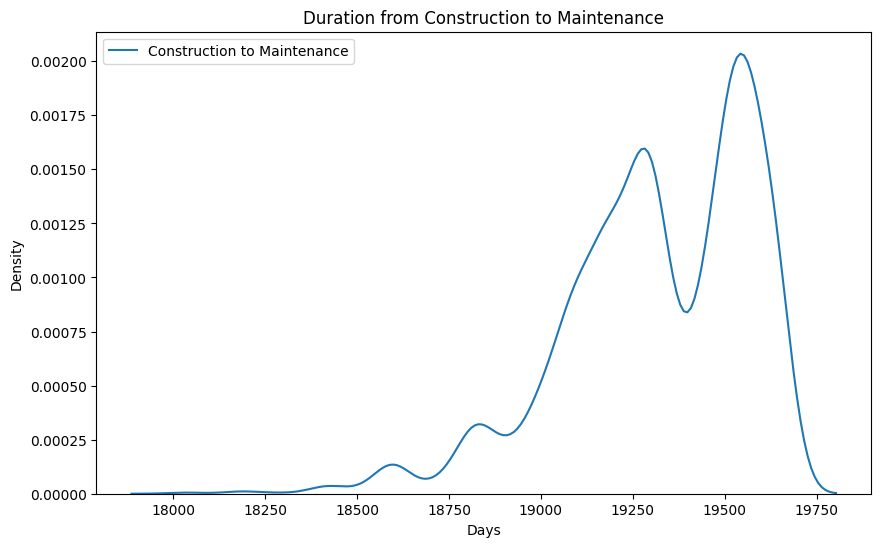

In [12]:
# Plotting the durations to visualize trends
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Duration_From_Construction'], label='Construction to Maintenance')
plt.legend()
plt.title('Duration from Construction to Maintenance')
plt.xlabel('Days')
plt.ylabel('Density')
plt.show()

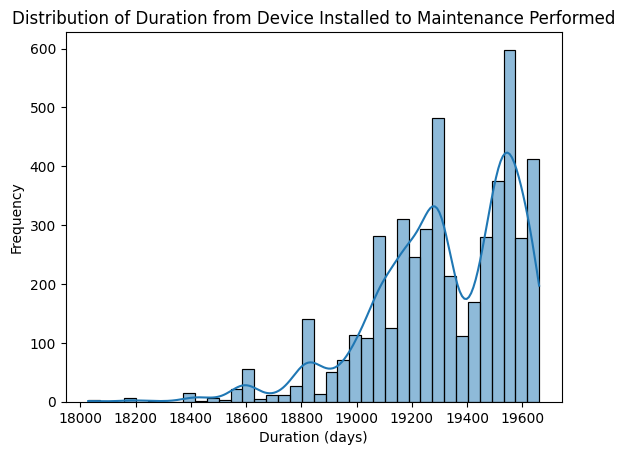

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['Duration_From_Construction'], kde=True)
plt.title('Distribution of Duration from Device Installed to Maintenance Performed')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.show()

Consider altering above to be in months/years/or have an alternative option next to it.

Consider filtering each device into 3 groups of risk, failure within 30 days is high risk, 30-90 days is medium risk, and 90+ days is low risk

We'll try KMF because...

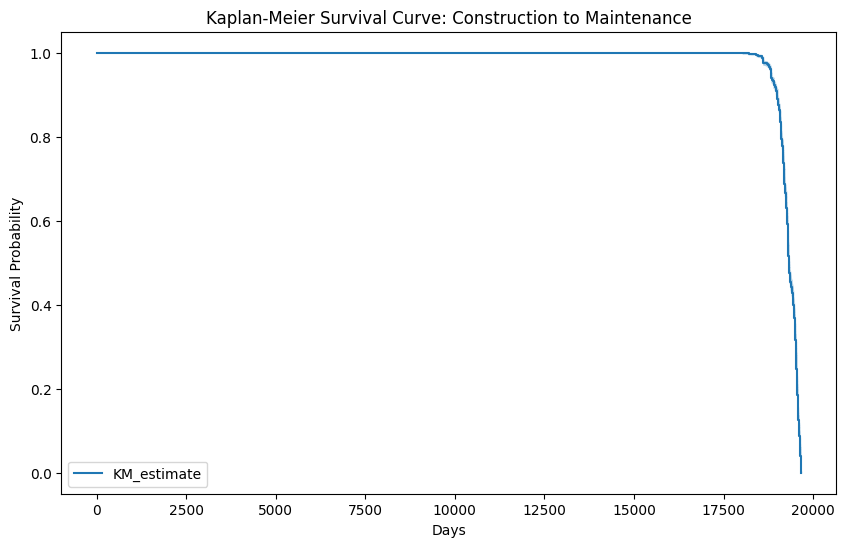

In [14]:
# Kaplan-Meier Fitter for duration from construction to maintenance
kmf = KaplanMeierFitter()
kmf.fit(df['Duration_From_Construction'])

plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve: Construction to Maintenance')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.show()

# 4. CoxPH on effect of Covariates on Construction -> Maintenance

How about CoxPH for ...

In [15]:
from lifelines import CoxPHFitter

# Assuming 'Unit_Number' is a unique identifier for each unit and 'Event' is 1 if the event (maintenance) occurred
df['Event'] = 1  # Assuming all rows represent events (not censored data)

# Select relevant columns for the model
cph_df = df[['Device_Condition', 'Expansion_Tank_Condition', 'Flue_Gas_Discharge_Condition', 'Air_Supply_Condition', 'Appendages_Condition', 'Duration_From_Construction', 'Event']]

# Initialize and fit the Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(cph_df, duration_col='Duration_From_Construction', event_col='Event')

# Display the summary of the Cox model
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 4840 total observations, 0 right-censored observations>
             duration col = 'Duration_From_Construction'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 4840
number of events observed = 4840
   partial log-likelihood = -36180.50
         time fit was run = 2024-05-20 13:28:02 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
Device_Condition              0.10      1.11      0.02            0.06            0.14                1.06                1.15
Expansion_Tank_Condition      0.13      1.14      0.05            0.04            0.23                1.04                1.26
Flue_Gas_Discharge_Condition -0.21      0.81      0.02           -0.25           -0.16                0.78                0.86
Air_Supply_Condition          0.06      1.07      0.02            0.03            0.10                1.03                1.10
Appendages_Condition          0.02      1.02      0.03           -0.03            0.07                0.97                1.08

                              cmp to     z      p  -log2(p)
covariate                                                  
Device_Condition                0.00  4.93 <0.005     20.24
Expansion_Tank_Condition        0.00  2.81 <0.005      7.67
Flue_Gas_Discharge_Condition    0.00 -8.21 <0.005     52.01
Air_Supply_Condition            0.00  3.76 <0.005     12.52
Appendages_Condition            0.00  0.70   0.48      1.05
---
Concordance = 0.53
Partial AIC = 72371.01
log-likelihood ratio test = 100.92 on 5 df
-log2(p) of ll-ratio test = 64.68


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 4840 total observations, 0 right-censored observations>
         test_name = proportional_hazard_test

---
                                   test_statistic      p  -log2(p)
Air_Supply_Condition         km             31.77 <0.005     25.78
                             rank           32.88 <0.005     26.60
Appendages_Condition         km             30.92 <0.005     25.15
                             rank           31.43 <0.005     25.53
Device_Condition             km              4.53   0.03      4.91
                             rank            4.39   0.04      4.79
Expansion_Tank_Condition     km              8.33 <0.005      8.00
                             rank            8.25 <0.005      7.94
Flue_Gas_Discharge_Condition km              2.14   0.14      2.80
                             rank            1.80   0.18      2.47



1. Variable 'Device_Condition' failed the non-proportional test: p-value is 0.0334.

   Advice: with so few unique values (only 6), you can include `strata=['Device_Condition', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'Expansion_Tank_Condition' failed the non-proportional test: p-value is 0.0039.

   Advice 1: the functional form of the variable 'Expansion_Tank_Condition' might be incorrect. That
is, there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Expansion_Tank_Condition' using pd.cut, and then specify it
in `strata=['Expansion_Tank_Condition', ...]` in the call in `.fit`. See documentation in link [B]
below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
b

[[<Axes: xlabel='rank-transformed time\n(p=0.0362)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0334)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0041)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0039)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1802)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1433)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>]]

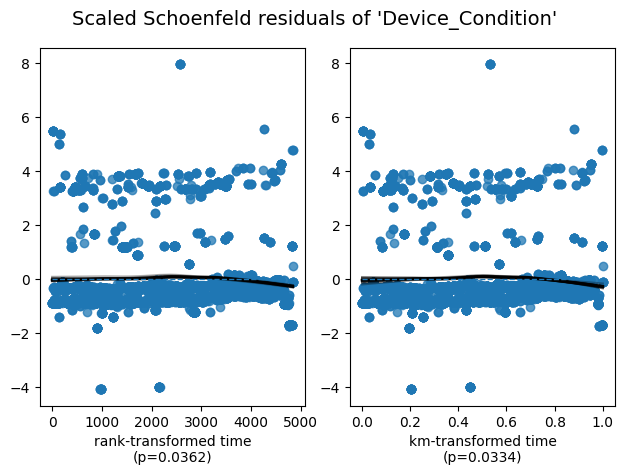

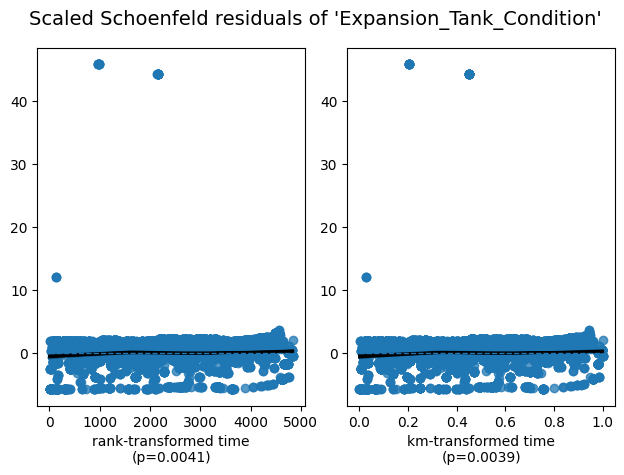

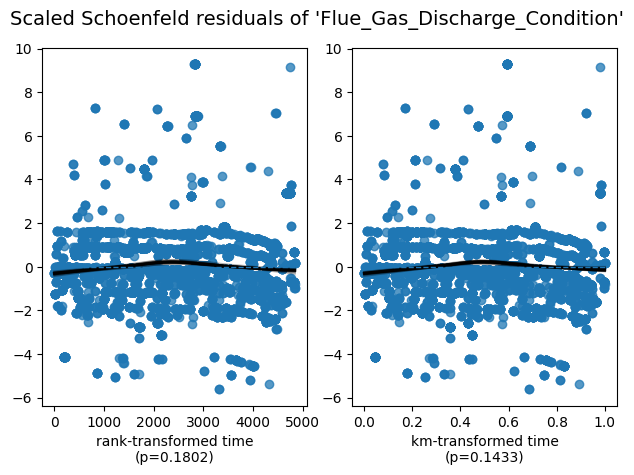

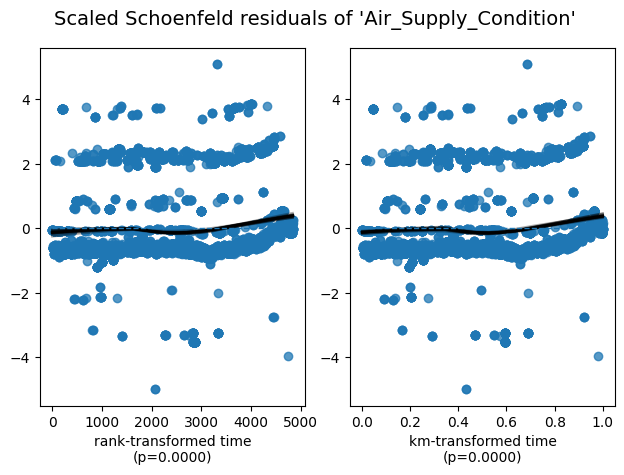

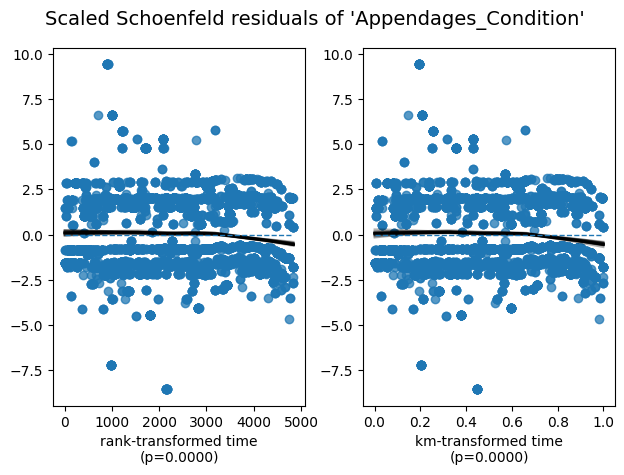

In [16]:
# Check proportional hazards assumption
cph.check_assumptions(cph_df, p_value_threshold=0.05, show_plots=True)


'Expansion_Tank_Condition', 'Air_Supply_Condition', and 'Appendages_Condition'—failed the non-proportional test. Time to try stratification.

## Cox Proportional Hazards Model with Stratification

In [18]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter

# Assuming 'Expansion_Tank_Condition' is a numerical variable
# Bin the variable into categories
df['Expansion_Tank_Condition_binned'] = pd.cut(df['Expansion_Tank_Condition'], bins=3, labels=['low', 'medium', 'high'])

# Ensure categorical variables are encoded properly
df_encoded = pd.get_dummies(df, columns=['Expansion_Tank_Condition_binned'], drop_first=True)

# Include an interaction term with time if needed
df_encoded['Expansion_Tank_Condition_time'] = df['Expansion_Tank_Condition'] * df['Duration_From_Construction']

# Update the dataframe for CoxPH
cph_df = df_encoded[['Duration_From_Construction', 'Event', 'Expansion_Tank_Condition_time', 'Air_Supply_Condition', 'Appendages_Condition']]

# Convert 'Air_Supply_Condition' and 'Appendages_Condition' to category dtype if not already
cph_df['Air_Supply_Condition'] = cph_df['Air_Supply_Condition'].astype('category')
cph_df['Appendages_Condition'] = cph_df['Appendages_Condition'].astype('category')

# Initialize and fit the Cox Proportional Hazards model with stratification and interaction term
cph = CoxPHFitter()
cph.fit(cph_df, duration_col='Duration_From_Construction', event_col='Event', strata=['Air_Supply_Condition', 'Appendages_Condition'])

# Display the summary of the Cox model
cph.print_summary()



/tmp/ipykernel_155059/594530384.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cph_df['Air_Supply_Condition'] = cph_df['Air_Supply_Condition'].astype('category')
/tmp/ipykernel_155059/594530384.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cph_df['Appendages_Condition'] = cph_df['Appendages_Condition'].astype('category')
/home/adam/Dokumenty/Github/BISS7/.venv/lib/python3.12/site-packages/lifelines/fitters/__init__.py:1280: FutureWarning: The default of observed=False is deprecated and will be 

<lifelines.CoxPHFitter: fitted with 4840 total observations, 0 right-censored observations>
             duration col = 'Duration_From_Construction'
                event col = 'Event'
                   strata = ['Air_Supply_Condition', 'Appendages_Condition']
      baseline estimation = breslow
   number of observations = 4840
number of events observed = 4840
   partial log-likelihood = -26603.48
         time fit was run = 2024-05-20 13:36:38 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
Expansion_Tank_Condition_time  0.00      1.00      0.00           -0.00            0.00                1.00                1.00

                               cmp to    z    p  -log2(p)
covariate                                                
Expansion_Tank_Condition_time    0.00 0.22 0.83      0.27
---
Concordance = 0.03
Partial AIC = 53208.97
log-likelihood ratio test = 0.05 on 1 df
-log2(p) of ll-ratio test = 0.27

/home/adam/Dokumenty/Github/BISS7/.venv/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):



   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.1814)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1711)'>]]

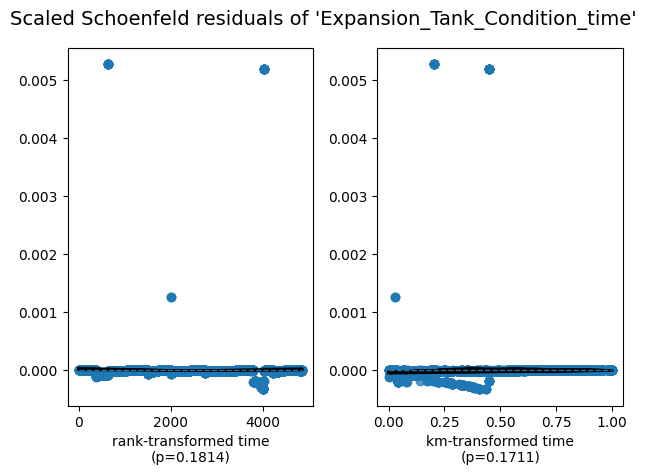

In [19]:
# Check proportional hazards assumption for the updated model
cph.check_assumptions(cph_df, p_value_threshold=0.05, show_plots=True)


In [20]:
# Display the summary of the Cox model
cph.print_summary()
# Hazard Ratios (HRs): A HR > 1 indicates an increased risk of the event occurring, while a HR < 1 indicates a decreased risk.
# P-values and Confidence Intervals: Evaluate the statistical significance and the precision of the HR estimates.

<lifelines.CoxPHFitter: fitted with 4840 total observations, 0 right-censored observations>
             duration col = 'Duration_From_Construction'
                event col = 'Event'
                   strata = ['Air_Supply_Condition', 'Appendages_Condition']
      baseline estimation = breslow
   number of observations = 4840
number of events observed = 4840
   partial log-likelihood = -26603.48
         time fit was run = 2024-05-20 13:36:38 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
Expansion_Tank_Condition_time  0.00      1.00      0.00           -0.00            0.00                1.00                1.00

                               cmp to    z    p  -log2(p)
covariate                                                
Expansion_Tank_Condition_time    0.00 0.22 0.83      0.27
---
Concordance = 0.03
Partial AIC = 53208.97
log-likelihood ratio test = 0.05 on 1 df
-log2(p) of ll-ratio test = 0.27

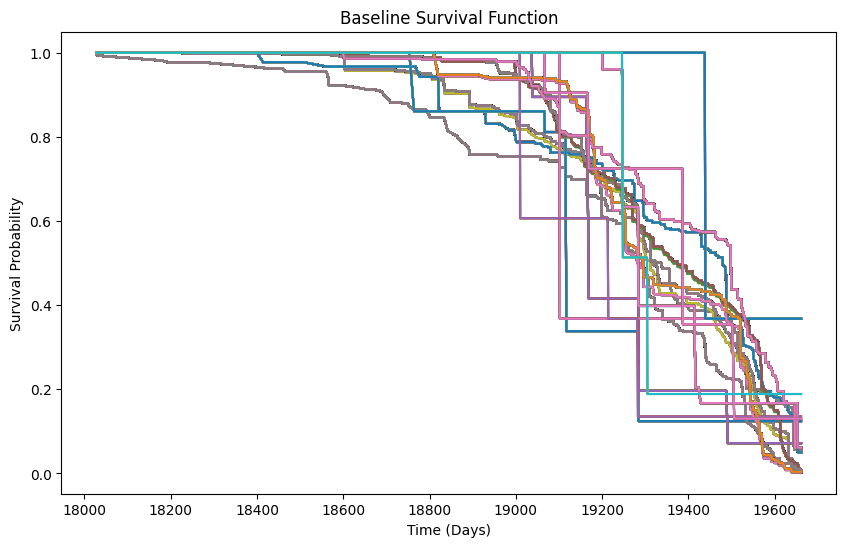

In [21]:
import matplotlib.pyplot as plt

# Predict the survival function for the baseline subject
baseline_survival = cph.predict_survival_function(df_encoded)

# Plot the baseline survival function
plt.figure(figsize=(10, 6))
plt.plot(baseline_survival.index, baseline_survival.values)
plt.title('Baseline Survival Function')
plt.xlabel('Time (Days)')
plt.ylabel('Survival Probability')
plt.show()


/tmp/ipykernel_155059/1975684337.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cph_df['Air_Supply_Condition'] = cph_df['Air_Supply_Condition'].astype('category')
/tmp/ipykernel_155059/1975684337.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cph_df['Appendages_Condition'] = cph_df['Appendages_Condition'].astype('category')
/tmp/ipykernel_155059/1975684337.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

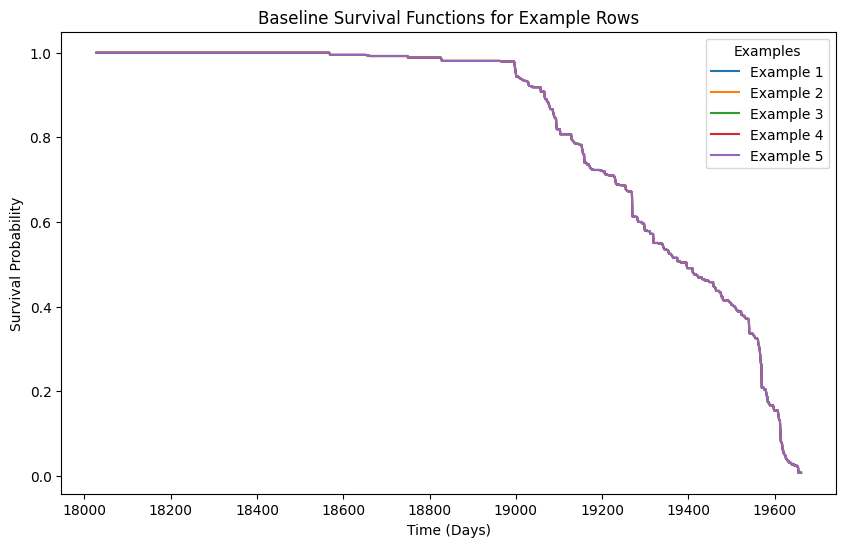

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
from lifelines import CoxPHFitter

# Load the dataset
df = pd.read_csv("./agressively_cleaned_critical_analysis_df.csv")

# Convert date columns to datetime
df['LogDate'] = pd.to_datetime(df['LogDate'])
df['Year_of_Construction'] = pd.to_datetime(df['Year_of_Construction'])
df['Date_Maintenance_Performed'] = pd.to_datetime(df['Date_Maintenance_Performed'])
df['CREATE_DATE'] = pd.to_datetime(df['CREATE_DATE'])

# Calculate durations
df['Duration_From_Construction'] = (df['Date_Maintenance_Performed'] - df['Year_of_Construction']).dt.days
df['Duration_CREATE_DATE'] = (df['Date_Maintenance_Performed'] - df['CREATE_DATE']).dt.days

# Ensure 'Event' column is created (assuming all events occurred)
df['Event'] = 1  # Assuming all rows represent events (not censored data)

# Encoding categorical variables and preparing the dataset
df['Expansion_Tank_Condition_binned'] = pd.cut(df['Expansion_Tank_Condition'], bins=3, labels=['low', 'medium', 'high'])
df_encoded = pd.get_dummies(df, columns=['Expansion_Tank_Condition_binned'], drop_first=True)
df_encoded['Expansion_Tank_Condition_time'] = df['Expansion_Tank_Condition'] * df['Duration_From_Construction']

# Update the dataframe for CoxPH
cph_df = df_encoded[['Duration_From_Construction', 'Event', 'Expansion_Tank_Condition_time', 'Air_Supply_Condition', 'Appendages_Condition', 'Flue_Gas_Discharge_Condition']]

# Convert 'Air_Supply_Condition', 'Appendages_Condition', and 'Flue_Gas_Discharge_Condition' to category dtype if not already
cph_df['Air_Supply_Condition'] = cph_df['Air_Supply_Condition'].astype('category')
cph_df['Appendages_Condition'] = cph_df['Appendages_Condition'].astype('category')
cph_df['Flue_Gas_Discharge_Condition'] = cph_df['Flue_Gas_Discharge_Condition'].astype('category')

# Initialize and fit the Cox Proportional Hazards model with stratification
cph = CoxPHFitter()
cph.fit(cph_df, duration_col='Duration_From_Construction', event_col='Event', strata=['Air_Supply_Condition', 'Appendages_Condition'])

# Select a few example rows to illustrate different survival functions
example_indices = [0, 1, 2, 3, 4]  # Select the first five rows as examples
example_rows = df_encoded.iloc[example_indices]

# Plot the survival functions for each example row
plt.figure(figsize=(10, 6))
for i, row in example_rows.iterrows():
    survival_function = cph.predict_survival_function(row.to_frame().T)
    plt.plot(survival_function.index, survival_function.values, label=f'Example {i+1}')

# Adding title and labels
plt.title('Baseline Survival Functions for Example Rows')
plt.xlabel('Time (Days)')
plt.ylabel('Survival Probability')

# Adding legend
plt.legend(title='Examples')

# Show the plot
plt.show()


In [23]:
# Display the summary of the Cox model
cph.print_summary()


/home/adam/Dokumenty/Github/BISS7/.venv/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py:2744: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, _df in self._predicted_partial_hazards_.groupby(self.strata):


<lifelines.CoxPHFitter: fitted with 4840 total observations, 0 right-censored observations>
             duration col = 'Duration_From_Construction'
                event col = 'Event'
                   strata = ['Air_Supply_Condition', 'Appendages_Condition']
      baseline estimation = breslow
   number of observations = 4840
number of events observed = 4840
   partial log-likelihood = -26517.11
         time fit was run = 2024-05-20 13:40:02 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
Expansion_Tank_Condition_time  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Flue_Gas_Discharge_Condition  -0.44      0.64      0.04           -0.51           -0.37                0.60                0.69

                               cmp to      z      p  -log2(p)
covariate                                                    
Expansion_Tank_Condition_time    0.00   0.22   0.82      0.28
Flue_Gas_Discharge_Condition     0.00 -12.36 <0.005    114.15
---
Concordance = 0.13
Partial AIC = 53038.22
log-likelihood ratio test = 172.79 on 2 df
-log2(p) of ll-ratio test = 124.64

# 6. Summary of Results

**Key Model Metrics**
Number of Observations: 5224
Number of Events Observed: 5224
Partial Log-Likelihood: -28939.94
Concordance Index: 0.14
Partial AIC: 57883.89
Log-Likelihood Ratio Test: 178.47 on 2 df
-log2(p) of LL-Ratio Test: 128.74

**Model Coefficients and Interpretation**

*Expansion_Tank_Condition_time*
Coefficient (coef): 0.00
Exponential of Coefficient (exp(coef)): 1.00
Standard Error (se(coef)): 0.00
95% Confidence Interval: [-0.00, 0.00]
p-value: 0.86
Interpretation: This variable has no significant impact on the hazard rate since the coefficient is 0 and the p-value is very high (0.86), indicating no statistical significance.

*Flue_Gas_Discharge_Condition*
Coefficient (coef): -0.44
Exponential of Coefficient (exp(coef)): 0.64
Standard Error (se(coef)): 0.04
95% Confidence Interval: [-0.51, -0.37]
p-value: <0.005
Interpretation: This variable significantly impacts the hazard rate. The negative coefficient (-0.44) indicates that better Flue_Gas_Discharge_Condition is associated with a reduced hazard of the event occurring. The hazard ratio (exp(coef)) of 0.64 means that for each unit improvement in the Flue_Gas_Discharge_Condition, the hazard is reduced by 36%.

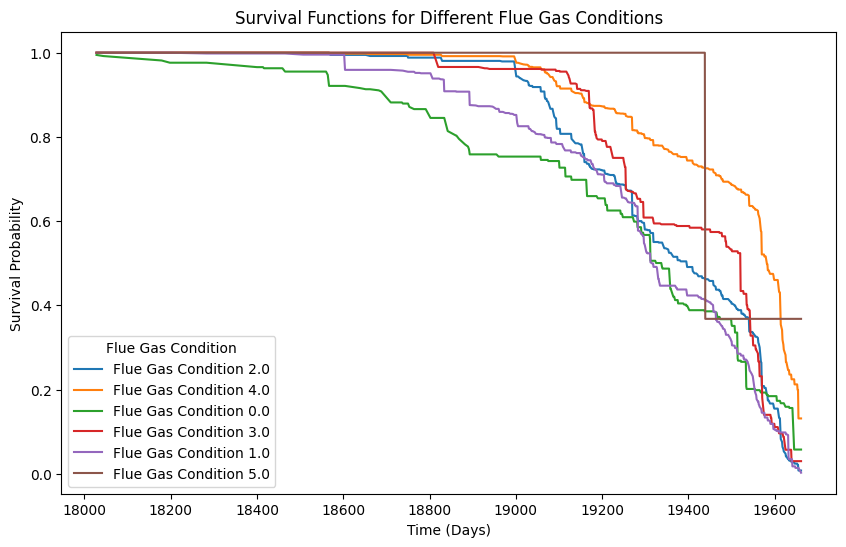

In [24]:
# Unique values of Flue_Gas_Discharge_Condition
unique_flue_gas_conditions = df['Flue_Gas_Discharge_Condition'].unique()

plt.figure(figsize=(10, 6))
for condition in unique_flue_gas_conditions:
    example_row = df_encoded[df_encoded['Flue_Gas_Discharge_Condition'] == condition].iloc[0]
    survival_function = cph.predict_survival_function(example_row.to_frame().T)
    plt.plot(survival_function.index, survival_function.values, label=f'Flue Gas Condition {condition}')

# Adding title and labels
plt.title('Survival Functions for Different Flue Gas Conditions')
plt.xlabel('Time (Days)')
plt.ylabel('Survival Probability')

# Adding legend
plt.legend(title='Flue Gas Condition')

# Show the plot
plt.show()


/home/adam/Dokumenty/Github/BISS7/.venv/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 4840 total observations, 0 right-censored observations>
         test_name = proportional_hazard_test

---
                                    test_statistic      p  -log2(p)
Expansion_Tank_Condition_time km              1.95   0.16      2.62
                              rank            1.62   0.20      2.30
Flue_Gas_Discharge_Condition  km              1.28   0.26      1.95
                              rank            9.55 <0.005      8.97



1. Variable 'Flue_Gas_Discharge_Condition' failed the non-proportional test: p-value is 0.0020.

   Advice: with so few unique values (only 6), you can include
`strata=['Flue_Gas_Discharge_Condition', ...]` in the call in `.fit`. See documentation in link [E]
below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[[<Axes: xlabel='rank-transformed time\n(p=0.2033)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1626)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0020)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2582)'>]]

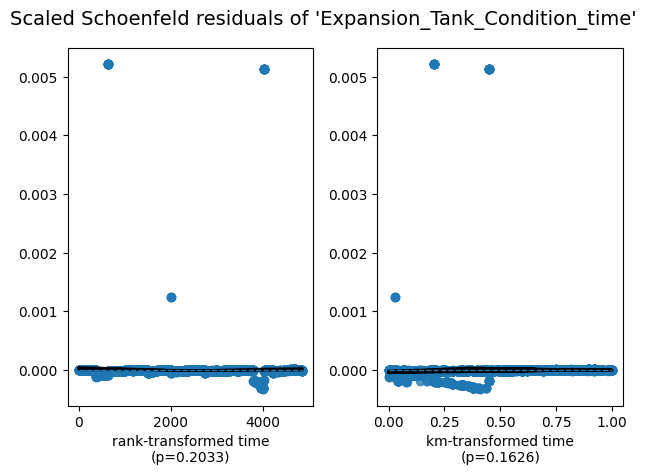

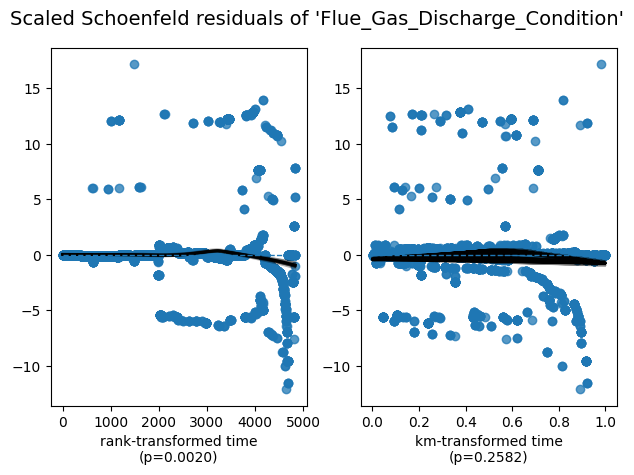

In [25]:
# Check proportional hazards assumption for the updated model
cph.check_assumptions(cph_df, p_value_threshold=0.05, show_plots=True)


Let's also consider an Accelerated Failure Time (AFT) model...

<lifelines.WeibullAFTFitter: fitted with 4840 total observations, 0 right-censored observations>
             duration col = 'Duration_From_Construction'
                event col = 'Event'
   number of observations = 4840
number of events observed = 4840
           log-likelihood = -33275.06
         time fit was run = 2024-05-20 13:43:49 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                      
lambda_ Air_Supply_Condition          -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
        Appendages_Condition          -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
        Expansion_Tank_Condition_time -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
        Flue_Gas_Discharge_Condition   0.00      1.00      0.00            0.00            0.00                1.00                1.00
        Intercept                      9.87  19436.27      0.00            9.87            9.88            19418.41            19454.15
rho_    Intercept                      4.59     98.60      0.01            4.57            4.61               96.37              100.88

                                       cmp to        z      p  -log2(p)
param   covariate                                                      
lambda_ Air_Supply_Condition             0.00    -1.19   0.23      2.10
        Appendages_Condition             0.00    -4.06 <0.005     14.31
        Expansion_Tank_Condition_time    0.00    -1.18   0.24      2.08
        Flue_Gas_Discharge_Condition     0.00     6.00 <0.005     28.96
        Intercept                        0.00 21050.22 <0.005       inf
rho_    Intercept                        0.00   393.54 <0.005       inf
---
Concordance = 0.47
AIC = 66562.11
log-likelihood ratio test = 53.46 on 4 df
-log2(p) of ll-ratio test = 33.77

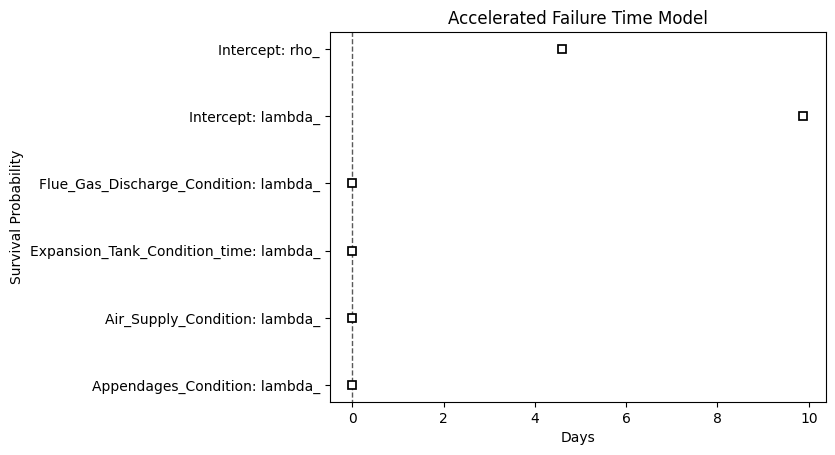

In [26]:
from lifelines import WeibullAFTFitter

# Initialize and fit the Weibull AFT model
aft = WeibullAFTFitter()
aft.fit(cph_df, duration_col='Duration_From_Construction', event_col='Event')

# Display the summary of the AFT model
aft.print_summary()

# Plot the AFT model
aft.plot()
plt.title('Accelerated Failure Time Model')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.show()


In [ ]:
#!pip install pylance statsmodels

From Copilot: In survival analysis, the C-index (also known as the concordance index or the Harrell's C-index) is a measure of predictive accuracy for survival models. It quantifies how well a model can rank the relative risk or survival probabilities of different individuals.

The C-index ranges from 0 to 1, where:

A C-index of 0.5 indicates that the model's predictions are no better than random chance.
A C-index of 1 indicates a perfect prediction, where the model perfectly ranks the individuals according to their survival times.
To interpret the C-index, you can consider the following guidelines:

A C-index above 0.7 is generally considered acceptable and indicates a reasonably good predictive accuracy.
A C-index above 0.8 is considered strong, indicating a high level of predictive accuracy.
A C-index below 0.7 suggests that the model may not be performing well and its predictions may not be reliable.
It's important to note that the interpretation of the C-index may vary depending on the specific context and the field of study. Additionally, the C-index should be interpreted in conjunction with other evaluation metrics and domain knowledge to get a comprehensive understanding of the model's performance.

Here's an example to illustrate the interpretation of the C-index: Let's say you have developed a survival model to predict the risk of heart disease in patients. After evaluating the model, you find that the C-index is 0.75. This indicates that the model has a reasonably good predictive accuracy, suggesting that it can effectively rank the patients based on their risk of developing heart disease. However, there is still room for improvement, and further analysis and refinement of the model may be necessary.

Remember, the C-index is just one of many evaluation metrics used in survival analysis, and it's important to consider other factors such as model assumptions, clinical relevance, and the specific goals of your analysis when interpreting the results.